# Loading libraries and functions

In [ ]:
%%capture
!pip install neurodsp
!pip install emd
!pip install tslearn
!pip install dtaidistance
!pip install sails

In [ ]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import dtw
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import copy
import sails

In [ ]:
def load_mat_data(path_to_data, file_name, states_file):
  data = loadmat(path_to_data + file_name)
  data = data['PFClfpCleaned'].flatten()

  states = loadmat(path_to_data + states_file)
  states = states['states'].flatten()
  return data, states

In [ ]:
def get_first_NREM_epoch(arr, start):
  start_index = None
  for i in range(start, len(arr)):
    if arr[i] == 3:
      if start_index is None:
        start_index = i
    elif arr[i] != 3 and start_index is not None:
      return (start_index, i - 1, i)

  return (start_index, len(arr) - 1, len(arr)) if start_index is not None else None

def get_all_NREM_epochs(arr):
  nrem_epochs = []
  next_start = 0
  while next_start < len(arr)-1:
    indices = get_first_NREM_epoch(arr, next_start)
    if indices == None:
      break
    start, end, next_start = indices
    if end-start <= 30:
      continue
    nrem_epochs.append([start, end])
  return nrem_epochs

In [ ]:
def peak_before_trough(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return arr[i]
  return -1

def peak_before_trough_pos(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return i
  return -1

def peak_to_trough_duration(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 20, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return trough_pos-i
  return -1

def num_inflection_points(arr):
  sign_changes = np.diff(np.sign(np.diff(arr, 2)))
  num_inflection_points = np.sum(sign_changes != 0)
  return num_inflection_points

def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

# Compute metrics for each cycle -
#     Maximum Amplitude
#     Cycle Duration
#     Trough Position and values
#     Peak (just before the trough) Position and Values
#     Peak Position and Values
#     Peak-to-Trough Duration
#     Peak to trough ratio ( P / P+T )
#     Ascending to Descending ratio ( A / A+D )
def get_cycles_with_metrics(cycles, data, IA, IF, conditions=None):
  C = copy.deepcopy(cycles)

  C.compute_cycle_metric('duration_samples', data, func=len)
  C.compute_cycle_metric('peak2trough', data, func=peak2trough)
  C.compute_cycle_metric('asc2desc', data, func=asc2desc)
  C.compute_cycle_metric('max_amp', IA, func=np.max)
  C.compute_cycle_metric('trough_values', data, func=np.min)
  C.compute_cycle_metric('peak_values', data, func=np.max)
  C.compute_cycle_metric('mean_if', IF, func=np.mean)
  C.compute_cycle_metric('max_if', IF, func=np.max)
  C.compute_cycle_metric('range_if', IF, func=compute_range)

  C.compute_cycle_metric('trough_position', data, func=np.argmin)
  C.compute_cycle_metric('peak_position', data, func=np.argmax)

  # C.compute_cycle_metric('peak_before_trough_val', nrem_filtered_data, func=peak_before_trough)
  # C.compute_cycle_metric('peak_before_trough_pos', nrem_filtered_data, func=peak_before_trough_pos)
  # C.compute_cycle_metric('avg_amp', IA, func=np.mean)
  # C.compute_cycle_metric('trough_position', nrem_filtered_data, func=np.argmin)
  # C.compute_cycle_metric('peak_position', nrem_filtered_data, func=np.argmax)
  # C.compute_cycle_metric('peak_to_trough_duration', nrem_filtered_data, func=peak_to_trough_duration)
  # C.compute_cycle_metric('num_inflection_points', nrem_filtered_data, func=num_inflection_points)
  # C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
  # C.compute_cycle_metric('stop_sample', imf, emd.cycles.cf_end_value)
  # C.compute_cycle_metric('peak_sample', imf, emd.cycles.cf_peak_sample)
  # C.compute_cycle_metric('desc_sample', imf, emd.cycles.cf_descending_zero_sample)
  # C.compute_cycle_metric('trough_sample', imf, emd.cycles.cf_trough_sample)
  return C

# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Loading sleep scoring data from MAT files stored in Google Drive.
path_to_data = '/content/drive/My Drive/Donders Internship/2018-07-26_14-20-46_Post-Trial5/'
data_file = 'PFClfpCleaned.mat'
states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'

# path_to_data = '/content/drive/My Drive/Donders Internship/data_13_CN/'
# data_file = 'Cleaned_Trial1_PFC_100_CH63_0.continuous.mat'
# states_file = '2019-05-13_11-24-48_post_trial1-states.mat'
pfc_data, sleep_scoring = load_mat_data(path_to_data, data_file, states_file)

nrem_epochs = np.array(get_all_NREM_epochs(sleep_scoring))
nrem_epochs

array([[ 873, 1592],
       [1681, 1974],
       [2016, 2080],
       [2133, 2179],
       [2192, 2347],
       [2356, 2445],
       [2606, 2932],
       [3075, 3251],
       [3279, 3366],
       [3450, 3552],
       [3667, 3710],
       [3728, 3796],
       [5370, 5412],
       [5440, 5501],
       [5518, 5602],
       [5609, 6047],
       [6112, 6267],
       [6333, 6394],
       [6417, 6604],
       [6637, 6721],
       [6728, 6823],
       [6870, 6916],
       [6928, 7044],
       [7084, 7151],
       [8583, 8671],
       [8684, 8747],
       [8781, 8954],
       [8982, 9117],
       [9190, 9314],
       [9345, 9427],
       [9574, 9737]])

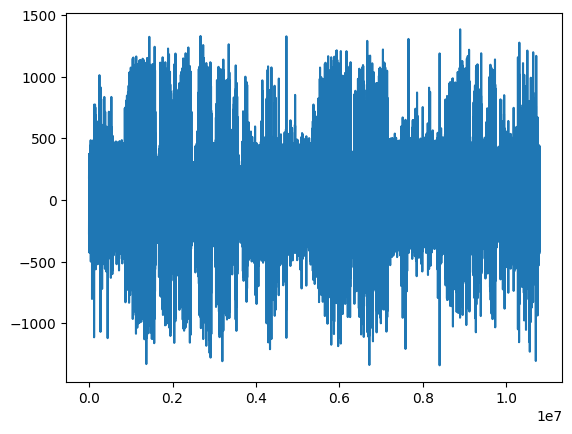

In [ ]:
plt.plot(pfc_data);

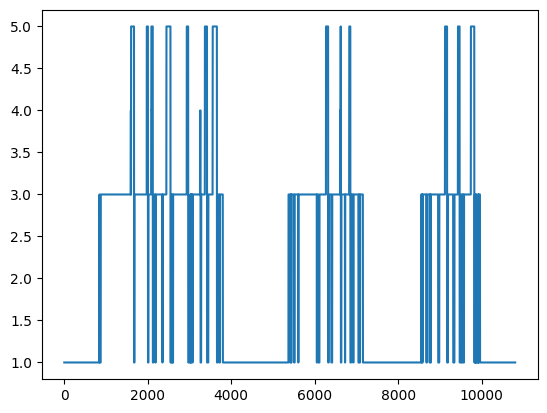

In [ ]:
plt.plot(sleep_scoring);

In [ ]:
len(pfc_data)/len(sleep_scoring)

1000.0773076566985

# Get All Cycles

In [ ]:
# Joining all the NREM epochs and filtering the Delta band

fs = 1000 # Sampling rate/frequency
nrem_data = []
for start, end in nrem_epochs:
  pfc_data_part = pfc_data[start*fs:end*fs]
  nrem_data.extend(pfc_data_part)
nrem_data = np.array(nrem_data)
nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)

# For testing, subset data
# nrem_filtered_data = nrem_filtered_data[:fs*60*10]

/usr/local/lib/python3.10/dist-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


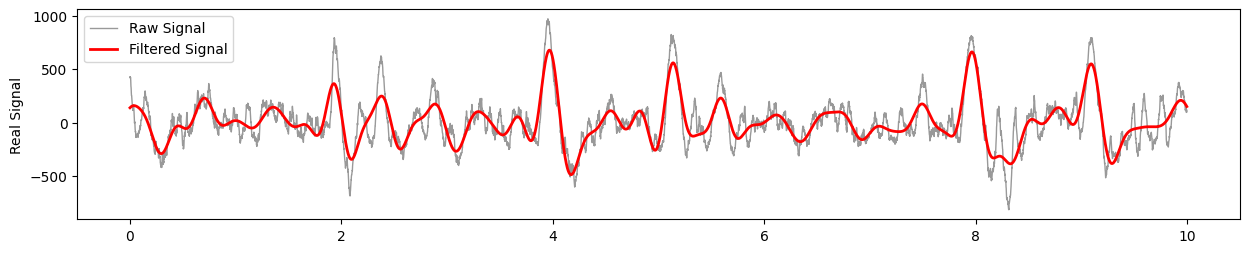

In [ ]:
# Plot NREM filtered data (10 sec window)

start = fs*200 # Start position for signal
length = 10

t = np.arange(fs*length) / fs
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,nrem_data[start:start+fs*length], 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,nrem_filtered_data[start:start+fs*length], 'r', label='Filtered Signal', lw=2)
plt.ylabel('Real Signal')
plt.legend()

In [ ]:
# Extract Instantaneous phase (IP), frequency and amplitude (from Hilbert Transform)
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, fs, 'hilbert')

# Get cycles using IP
C = emd.cycles.Cycles(IP)

 Checking Cycles inputs - trimming singleton from input 'IP'


In [ ]:
cycles = get_cycles_with_metrics(C, nrem_filtered_data, IA, IF)

In [ ]:
def get_cycles_with_conditions(cycles, fs, conditions):
  C = copy.deepcopy(cycles)
  metrics = C.get_metric_dataframe()

  amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
  peak_thresh = np.percentile(metrics['peak_values'], 85)
  trough_thresh = np.percentile(metrics['trough_values'], 40)

  lo_freq_duration = fs/0.1
  hi_freq_duration = fs/4

  C.pick_cycle_subset(conditions)
  return C

In [ ]:
metrics = cycles.get_metric_dataframe()
amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
peak_thresh = np.percentile(metrics['peak_values'], 85)
trough_thresh = np.percentile(metrics['trough_values'], 40)
lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [ ]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
all_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [ ]:
metrics = all_cycles.get_metric_dataframe(subset=True)
metrics

,index,is_good,duration_samples,peak2trough,asc2desc,max_amp,trough_values,peak_values,mean_if,max_if,range_if,trough_position,peak_position,chain_ind
0,8,1,498,0.479568,0.565421,385.419236,-385.061739,268.741512,2.008000,2.288361,0.926787,353,137,0
1,15,1,832,0.663332,0.512087,577.478296,-464.338443,335.883058,1.201157,1.832108,1.595199,668,262,1
2,23,1,420,0.414319,0.589829,465.991827,-372.621361,308.257680,2.386341,6.268422,4.437658,267,95,2
3,29,1,593,0.370283,0.667139,560.010542,-372.123774,481.054485,1.687476,2.618704,1.951302,317,119,3
4,69,1,466,0.389308,0.623549,515.758008,-392.530321,495.202314,2.147114,2.919865,1.876605,268,93,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790,9983,1,624,0.188361,0.717643,468.194441,-409.215842,193.802866,1.601457,7.891810,7.793397,233,57,1845
2791,9987,1,693,0.487236,0.672330,444.316463,-440.601166,189.675638,1.442929,2.216349,1.463274,475,248,1846
2792,9990,1,783,0.605851,0.726610,487.763041,-282.780497,197.334035,1.277633,2.493442,2.385485,595,381,1847
2793,10000,1,472,0.412788,0.545241,619.922038,-619.121028,390.620448,2.120472,2.662690,1.065864,322,107,1848


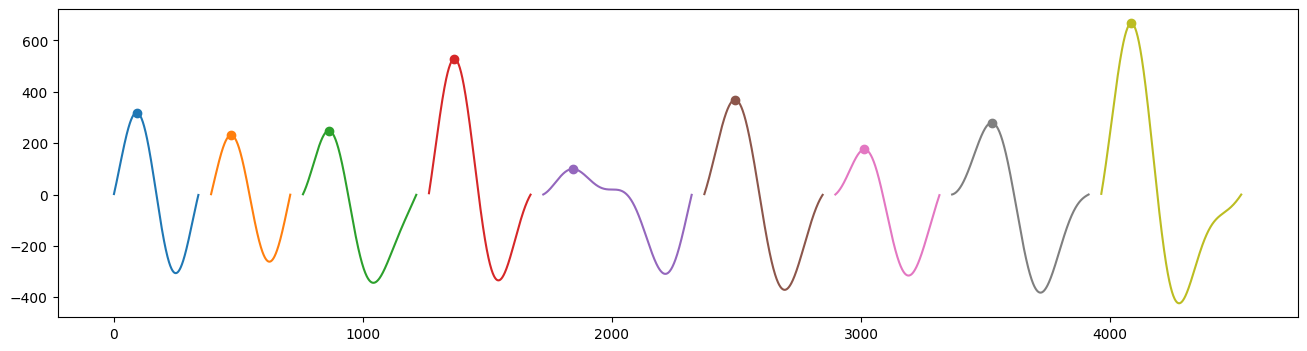

In [ ]:
cycles_to_plot = metrics['index'][11:20]
plt.figure(figsize=(16,4))
start = 0
for ii in cycles_to_plot:
  inds = cycles.get_inds_of_cycle(ii)
  cycle = nrem_filtered_data[inds]
  row = metrics[metrics['index'] == ii]
  xinds = np.arange(len(inds)) + start
  plt.plot(xinds, cycle)
  plt.scatter(row['peak_position']+start, row['peak_values'])

  start += len(inds)+50

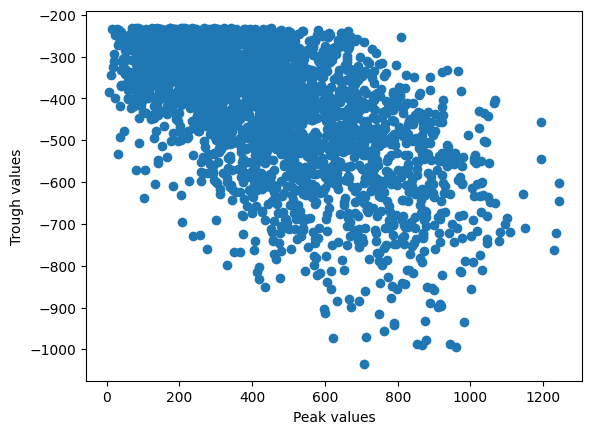

In [ ]:
fig = px.density_contour(metrics, x="peak_values", y="trough_values", marginal_x="histogram", marginal_y="histogram")
fig.show()

plt.scatter(metrics['peak_values'], metrics['trough_values'])
plt.xlabel('Peak values')
plt.ylabel('Trough values');

# Get SO and delta cycles

In [ ]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
so_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [ ]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
delta_cycles = get_cycles_with_conditions(cycles, fs, conditions)

In [ ]:
metrics_so = so_cycles.get_metric_dataframe(subset=True)
metrics_delta = delta_cycles.get_metric_dataframe(subset=True)

(0.0, 600.0)

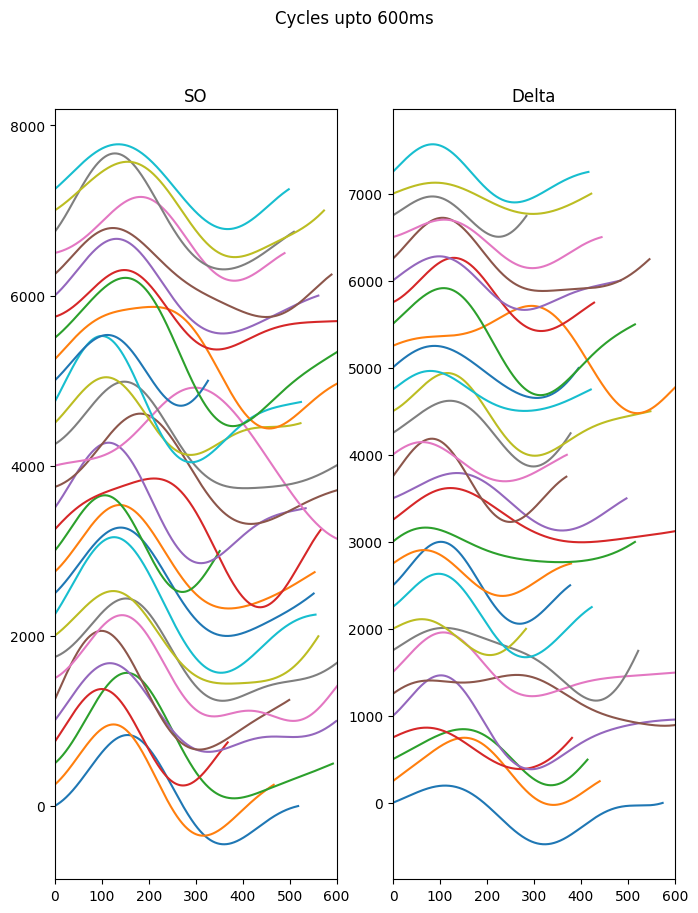

In [ ]:
plt.figure(figsize=(8,10))
plt.suptitle("Cycles upto 600ms")

plt.subplot(1, 2, 1)
plt.title('SO')
start = 0
cycles_to_plot_so = np.random.choice(metrics_so['index'], 30)
for i in cycles_to_plot_so:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  plt.plot(cycle+start)
  start += 250
plt.xlim((0,600))

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot_delta = np.random.choice(metrics_delta['index'], 30)
for i in cycles_to_plot_delta:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  plt.plot(cycle+start)
  start += 250
plt.xlim((0,600))

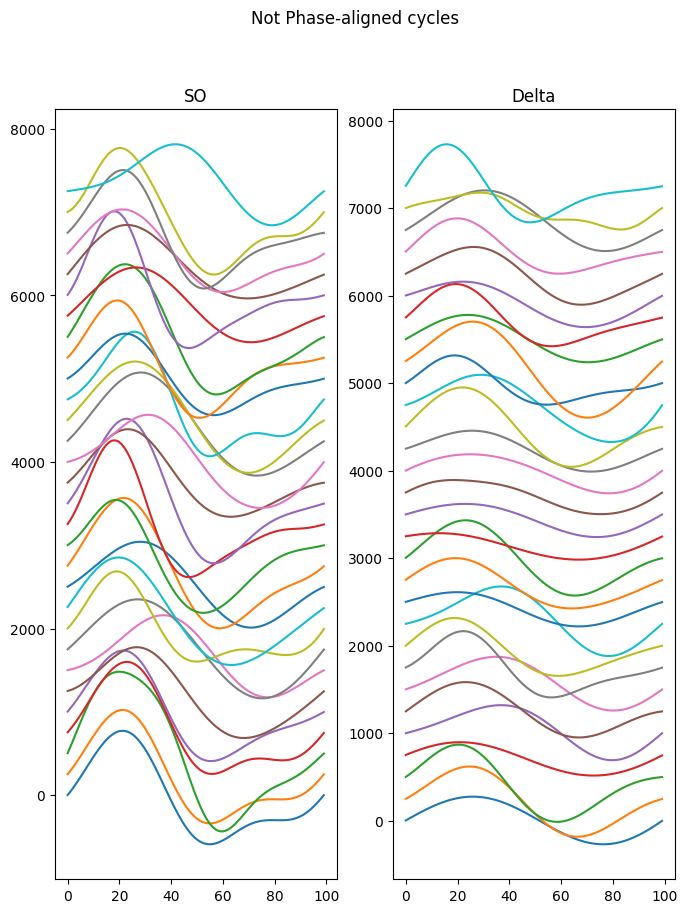

In [ ]:
plt.figure(figsize=(8,10))
plt.suptitle("Not Phase-aligned cycles")

plt.subplot(1, 2, 1)
plt.title('SO')
# plt.yticks([])
start = 0
cycles_to_plot_so = np.random.choice(metrics_so['index'], 30)
for i in cycles_to_plot_so:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  new_length = 100
  new_indices = np.linspace(0, len(cycle) - 1, new_length)

  interpolator = interp1d(np.arange(len(cycle)), cycle, kind='linear')
  downsampled_series = interpolator(new_indices)

  plt.plot(downsampled_series+start)
  # plt.plot(so_waveforms[:,i]+start)
  start += 250

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot_delta = np.random.choice(metrics_delta['index'], 30)
for i in cycles_to_plot_delta:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  new_length = 100
  new_indices = np.linspace(0, len(cycle) - 1, new_length)

  interpolator = interp1d(np.arange(len(cycle)), cycle, kind='linear')
  downsampled_series = interpolator(new_indices)

  plt.plot(downsampled_series+start)
  start += 250

# Phase-aligned cycles

In [ ]:
so_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=so_cycles.iterate(through='subset'), npoints=100)
delta_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=delta_cycles.iterate(through='subset'), npoints=100)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


(-1000.0, 7000.0)

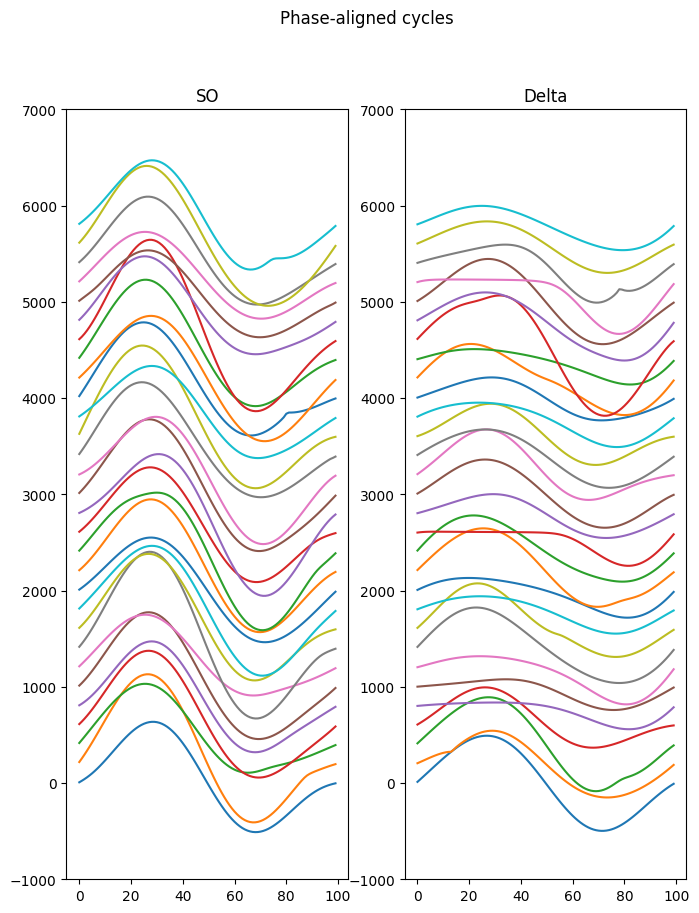

In [ ]:
plt.figure(figsize=(8,10))
plt.suptitle("Phase-aligned cycles")
plt.subplot(1, 2, 1)
plt.title('SO')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, so_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(so_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, delta_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(delta_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# Analysis of IP and IF

(-5.0, 5.0)

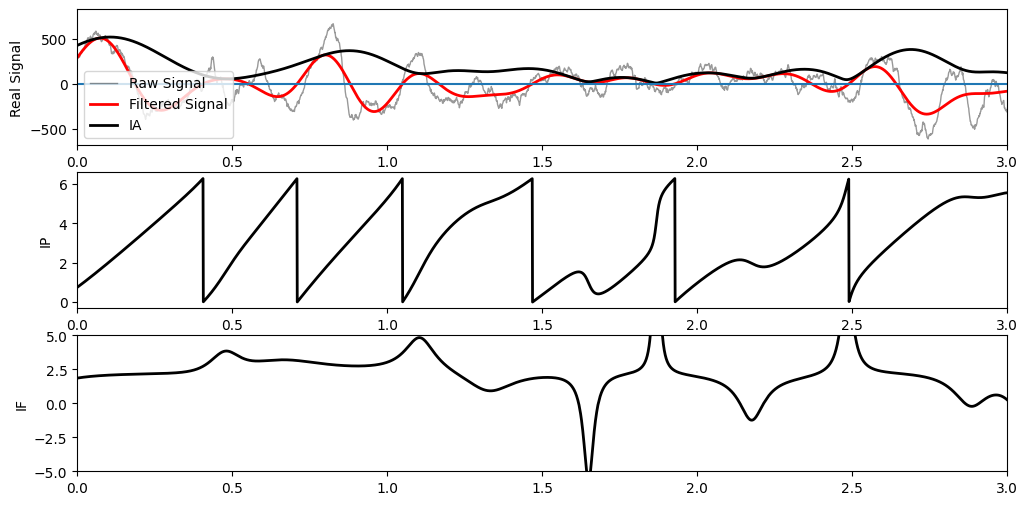

In [ ]:
# Plot IA, IP, IF for a particular cycle (n sec window)

start = fs*50 # Start position for signal
length = 8

t = np.arange(fs*length) / fs
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(t,nrem_data[start:start+fs*length], 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,nrem_filtered_data[start:start+fs*length], 'r', label='Filtered Signal', lw=2)
plt.plot(t,IA[start:start+fs*length], 'k', label='IA', lw=2)
plt.ylabel('Real Signal')
plt.axhline(0)
plt.xlim((0, 3))
plt.legend();

plt.subplot(3,1,2)
plt.plot(t,IP[start:start+fs*length], 'k', label='IP', lw=2)
plt.ylabel('IP')
plt.xlim((0, 3))

plt.subplot(3,1,3)
plt.plot(t,IF[start:start+fs*length], 'k', label='IP', lw=2)
plt.ylabel('IF')
plt.xlim((0, 3))
plt.ylim((-5, 5))

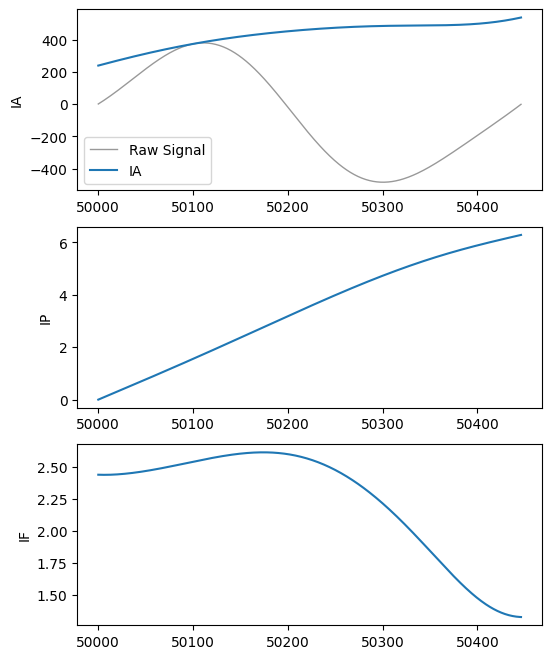

In [ ]:
# Plot IA, IP, IF for a particular cycle

cycle_to_plot = 600

inds = cycles.get_inds_of_cycle(all_metrics['index'][cycle_to_plot])

plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
cycle = IA[inds]
plt.plot(np.arange(len(inds)) + start,nrem_filtered_data[inds], 'k', label='Raw Signal', alpha=0.4, lw=1);
plt.plot(np.arange(len(inds)) + start, cycle, label='IA');
plt.legend()
plt.ylabel('IA')

plt.subplot(3,1,2)
cycle = IP[inds]
plt.plot(np.arange(len(inds)) + start, cycle);
plt.ylabel('IP')

plt.subplot(3,1,3)
cycle = IF[inds]
plt.plot(np.arange(len(inds)) + start, cycle);
plt.ylabel('IF');

In [ ]:
pa, phasex = emd.cycles.phase_align(IP, IF, all_cycles.iterate(through='subset'))

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'


In [ ]:
pc_data = pa.T

# Have to center because Sails PCA works with, only the y axis of the cycle is required, the x feature vector centering is done by SAILS PCA
cycle_mean = pc_data.mean(axis=1)[:, None]
phase_mean = pc_data.mean(axis=0)[:, None]

pc_data = pc_data - cycle_mean

In [ ]:
bads, _ = sails.utils.gesd(pc_data.std(axis=1))
goods = bads == False

In [ ]:
pca = sails.utils.PCA(pc_data[goods, :], npcs=10)

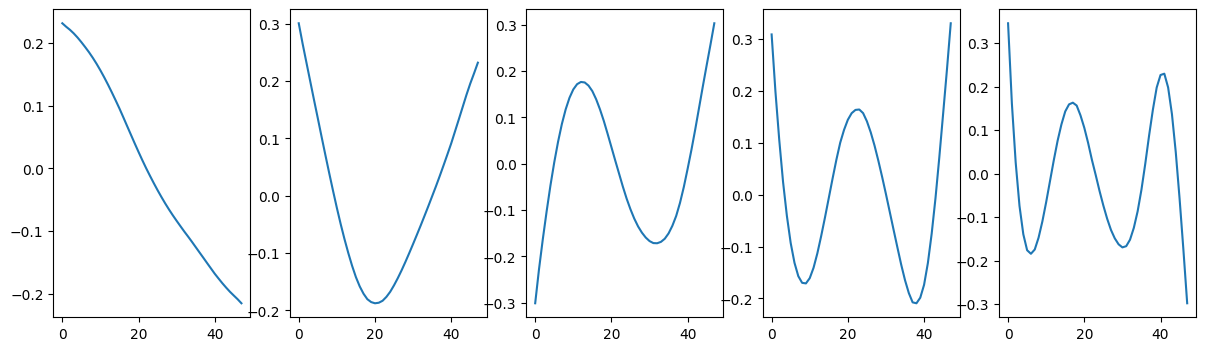

In [ ]:
plt.figure(figsize=(30, 4))

for i in range(5):
  plt.subplot(1, len(pca.components), i+1)
  pc = pca.components[i]
  plt.plot(pc, label='PC')

In [ ]:
def projection(pca, projection_score=0):
  pc_proj = np.zeros((pca.data_mean.shape[1], 10))
  for ii in range(10):
      sc = np.zeros(10)
      sc[ii] = projection_score
      pc_proj[:, ii] = (pca.project_score(sc).T + phase_mean).reshape(-1)
  return pc_proj

Text(0.5, 1.0, 'PCA 2, val: -7')

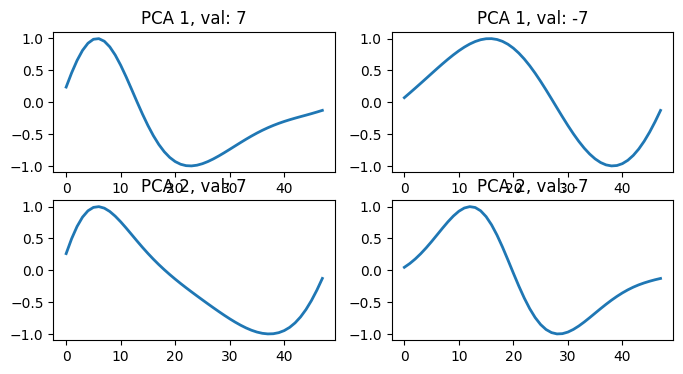

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(2,2,1)
val = 7
pc_proj = projection(pca, val)
sr = pc_proj[:, 0].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2);
plt.title(f"PCA 1, val: {val}")
# plt.legend()

plt.subplot(2,2,2)
val = -7
pc_proj = projection(pca, val)
sr = pc_proj[:, 0].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2);
plt.title(f"PCA 1, val: {val}")

plt.subplot(2,2,3)
val = 7
pc_proj = projection(pca, val)
sr = pc_proj[:, 1].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2);
plt.title(f"PCA 2, val: {val}")

plt.subplot(2,2,4)
val = -7
pc_proj = projection(pca, val)
sr = pc_proj[:, 1].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2);
plt.title(f"PCA 2, val: {val}")

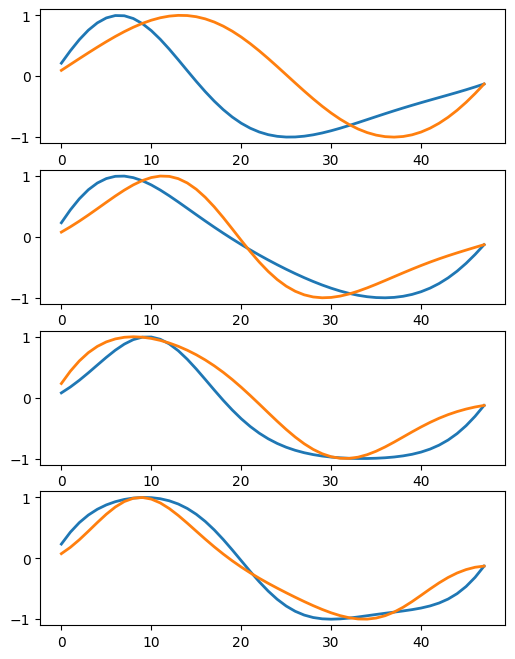

In [ ]:
pc_proj = np.zeros((48, 2, 10))
val = 5  # PC-score to project
for ii in range(10):
    sc = np.zeros((2, 10))
    sc[0, ii] = val
    sc[1, ii] = -val
    pc_proj[:, :, ii] = pca.project_score(sc).T + phase_mean

plt.figure(figsize=(6,8))
plt.subplot(4,1,1)
sr = pc_proj[:, 0, 0].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 0], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 0].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 0], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

plt.subplot(4,1,2)
sr = pc_proj[:, 0, 1].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 1], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 1].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 1], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

plt.subplot(4,1,3)
sr = pc_proj[:, 0, 2].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 2], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 2].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 2], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

plt.subplot(4,1,4)
sr = pc_proj[:, 0, 3].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 3], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 3].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 3], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

In [ ]:
pa_waveform, _ = emd.cycles.phase_align(IP, IF, all_cycles.iterate(through='subset'))
norm_waveform, sine = emd.cycles.normalised_waveform(pa_waveform)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'


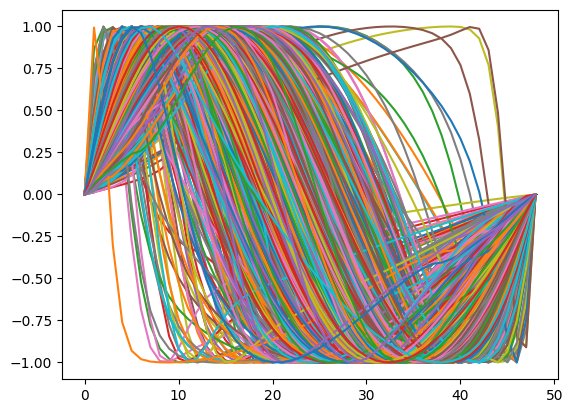

In [ ]:
plt.plot(norm_waveform);

# Rate of SO and delta cycles

In [ ]:
def get_masked_cycles(IP, cycles):
  mask = np.full(cycles.nsamples, False)
  subset_cycles = cycles.get_metric_dataframe(subset=True)['index']

  for i in subset_cycles:
    inds = cycles.get_inds_of_cycle(i)
    mask[inds] = True

  masked_so_cycles = emd.cycles.get_cycle_vector(IP, mask=mask)
  return masked_so_cycles

In [ ]:
def rate_cycle(cycles_vector, duration=1, fs=1000):
  samples_per_segment = duration * fs
  segments = np.array_split(cycles_vector, np.arange(samples_per_segment, len(cycles_vector), samples_per_segment))
  segments = np.array(segments[:-1])

  rate = []
  for segment in segments:
    if -1 in segment:
      rate.append(len(np.unique(segment))-1)
    else:
      rate.append(len(np.unique(segment)))
  rate = np.array(rate)
  rate = rate/duration
  return rate, segments

In [ ]:
so_cycles_vector = get_masked_cycles(IP, so_cycles)
delta_cycles_vector = get_masked_cycles(IP, delta_cycles)

In [ ]:
so_cycles_rate, _ = rate_cycle(so_cycles_vector, duration=10)
delta_cycles_rate, _ = rate_cycle(delta_cycles_vector, duration=10)

Text(0.5, 0, 'Time (10 sec windows)')

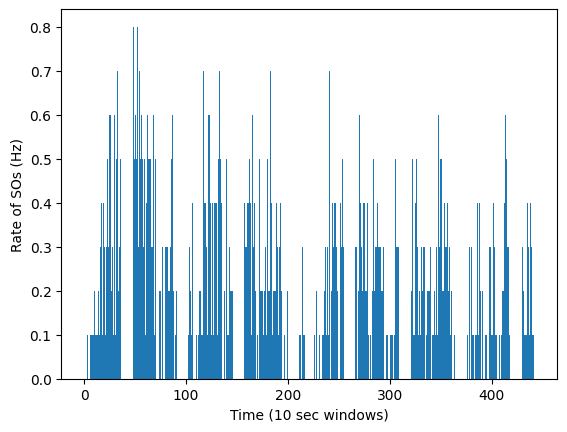

In [ ]:
plt.bar(range(len(so_cycles_rate)), so_cycles_rate)
plt.ylabel("Rate of SOs (Hz)")
plt.xlabel("Time (10 sec windows)")

Text(0.5, 0, 'Time (10 sec windows)')

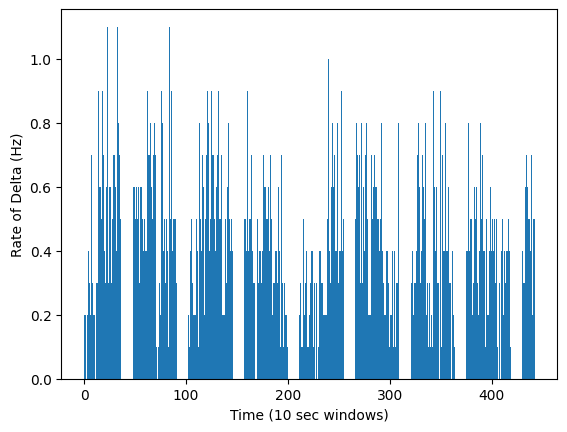

In [ ]:
plt.bar(range(len(delta_cycles_rate)), delta_cycles_rate)
plt.ylabel("Rate of Delta (Hz)")
plt.xlabel("Time (10 sec windows)")

Text(0.5, 9.444444444444438, 'Number of SOs in 3 sec window')

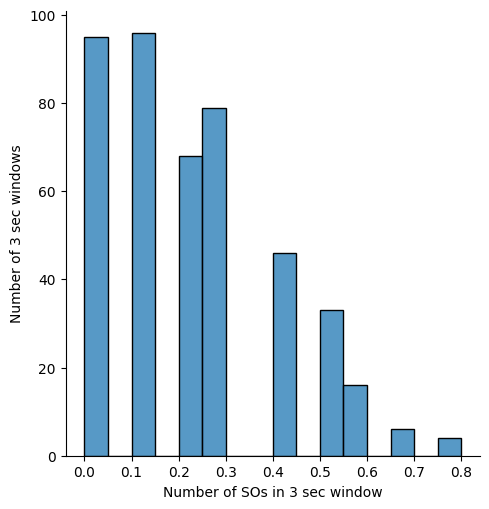

In [ ]:
import seaborn as sns

sns.displot(so_cycles_rate);
plt.ylabel("Number of 3 sec windows")
plt.xlabel("Number of SOs in 3 sec window")

# PCA on metrics

In [ ]:
pca_df = all_metrics[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]

In [ ]:
pca_df

,duration_samples,peak2trough,asc2desc,max_amp,peak_values,trough_values,mean_if,max_if,range_if
0,498,0.479568,0.565421,385.419236,268.741512,-385.061739,2.008000,2.288361,0.926787
1,832,0.663332,0.512087,577.478296,335.883058,-464.338443,1.201157,1.832108,1.595199
2,420,0.414319,0.589829,465.991827,308.257680,-372.621361,2.386341,6.268422,4.437658
3,593,0.370283,0.667139,560.010542,481.054485,-372.123774,1.687476,2.618704,1.951302
4,466,0.389308,0.623549,515.758008,495.202314,-392.530321,2.147114,2.919865,1.876605
...,...,...,...,...,...,...,...,...,...
2790,624,0.188361,0.717643,468.194441,193.802866,-409.215842,1.601457,7.891810,7.793397
2791,693,0.487236,0.672330,444.316463,189.675638,-440.601166,1.442929,2.216349,1.463274
2792,783,0.605851,0.726610,487.763041,197.334035,-282.780497,1.277633,2.493442,2.385485
2793,472,0.412788,0.545241,619.922038,390.620448,-619.121028,2.120472,2.662690,1.065864


In [ ]:
pca = sails.utils.PCA(np.array(pca_df), npcs=5)

In [ ]:
pca.scores[:, 0]

array([229.70610323, -40.0680951 , 177.84893019, ..., 182.68930425,
       -68.74078181, 156.29657768])

In [ ]:
plt.

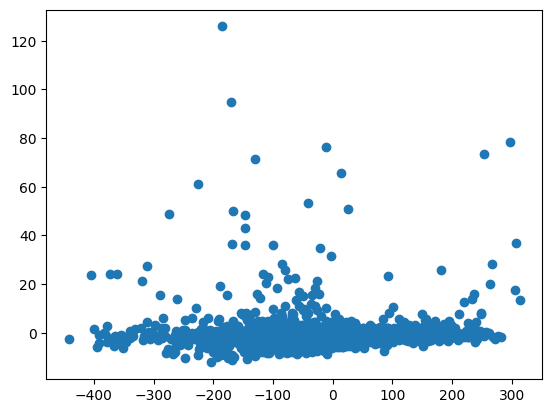

In [ ]:
plt.scatter(pca.scores[:, 2], pca.scores[:, 4])

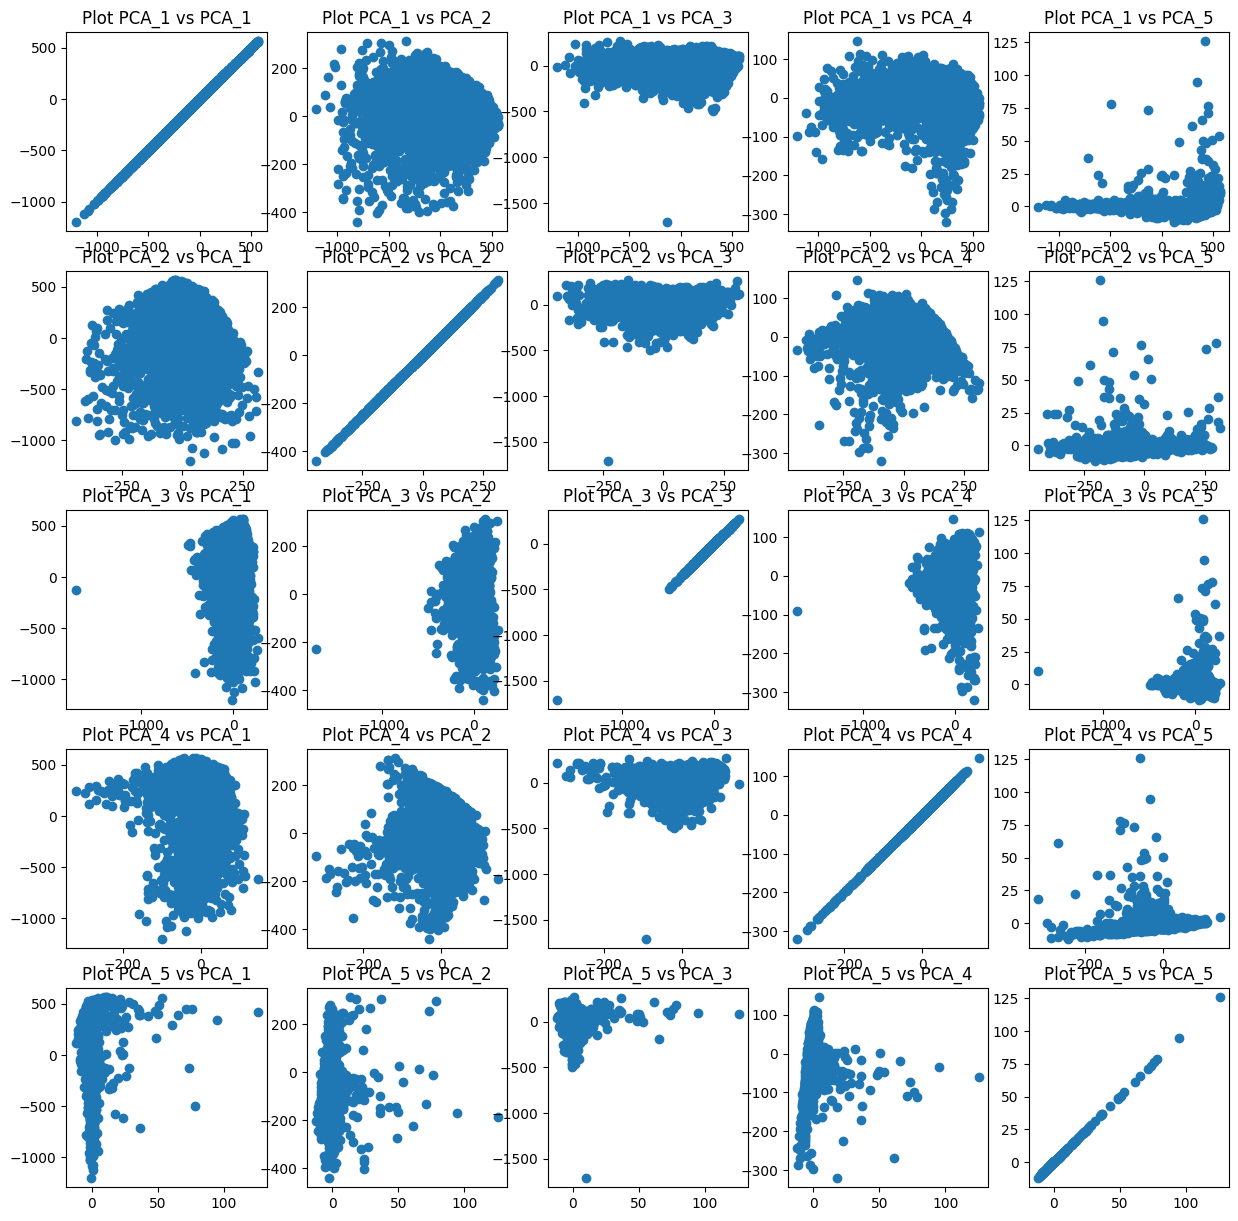

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i in range(5):
    for j in range(5):
        axes[i, j].scatter(pca.scores[:, i], pca.scores[:, j])  # Example: each plot has a different sine wave
        axes[i, j].set_title(f"Plot PCA_{i+1} vs PCA_{j+1}")

In [ ]:
n_components = 5

# Create a figure with a 5x5 grid of subplots
fig, axes = plt.subplots(n_components, n_components, figsize=(15, 15))

# Loop to create scatter plots
for i in range(n_components):
    for j in range(n_components):
        if i == j:
            axes[i, j].text(0.5, 0.5, f'PC{i+1}', fontsize=12, ha='center')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
        elif i > j:
            axes[i, j].scatter(pca_features[:, j], pca_features[:, i])
            axes[i, j].set_xlabel(f'PC{j+1}')
            axes[i, j].set_ylabel(f'PC{i+1}')
        else:
            axes[i, j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()